In [291]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
from xmitgcm import open_mdsdataset
import cmocean as co
import seaborn as sns
from os import sys

sns.set_context(context='paper', font_scale=1.5)

This notebook demonstrates how to build a numerical model of the experiment performed in Hoggs 2017 based on the MITGCM tutorial "plume_on_slope".

The notebook ...
- summarizes the experiment setup in Hoggs 2017.
- derives parameters to be set for the numerical simulation.
- builds input files to run the MITGCM.
- lists additional steps needed to successfully run the simulation.

### 0. Set path

Set path were to write binary input files to.

In [292]:
path = '/Users/ndettling/mitgcm/temp/MITgcm/verification/tutorial_plume_on_slope_Hoggs/input/'

### 1. Experiment design in Hoggs 2017

#### The experiment setup is as follows:

1. Two-layered fluid ($\rho_1$, $\rho_2$)
2. Sloped bottom topography (slope angle $\theta$)
3. Lock containing denser fluid ($\rho_3$) to create gravity current flowing down the slope upon release
4. Lock building up fluid with $\rho_2$ to create internal wave upon release
5. Lock release timed so that gravity current and wave collide at B
6. Internal wave Froude number (a/L) varied with fluid height a

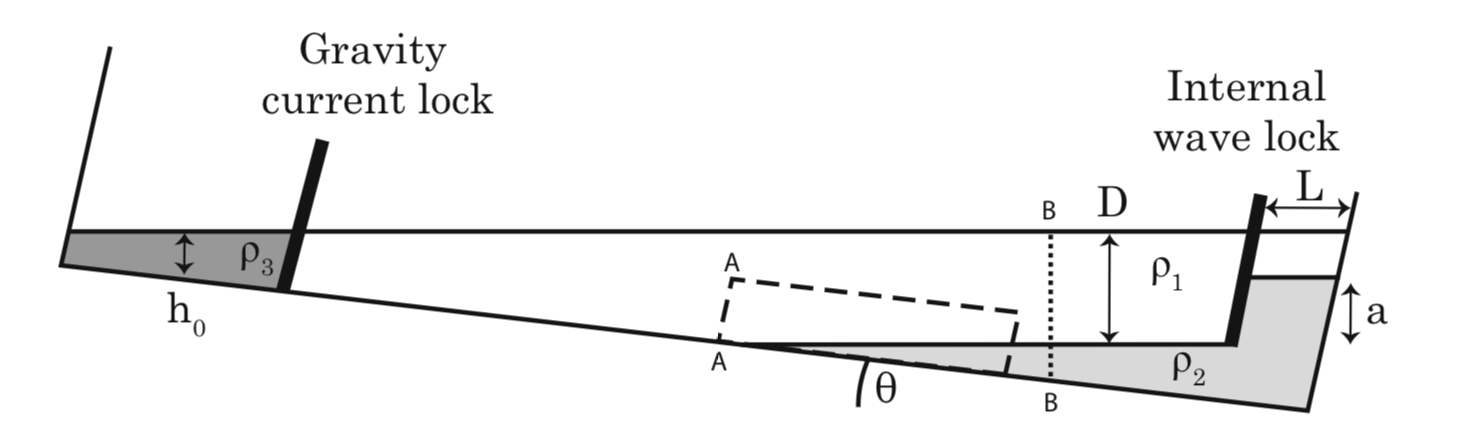

In the experiment, the locks are drawn out and a gravity current flows down the slope. Once the gravity current has passed the density interface, it is met by a gravity wave coming from the other side. The authors then measure the volume transport and thickness of the gravity current as a function of Froude number (~wave intensity).

### 2. Experiment parameters

In Hoggs 2017, parameters were chosen as follows:

- $h_0$ = 0.025m
- $\theta$ = 5.4 deg.
- D = 0.054m
- L = 0.124m 
- $R_i$ = 3.9
- Fr = a/L = 0-0.3 (varied)

In order to recreate the tank experiment in a numerical simulation, the following theoretical dependencies may be of use:

$$
R_i = \frac{g_i' \cdot D}{g_c' \cdot h_0}
$$


$$
g_i' = \frac{g(\rho_2 - \rho_1)}{\rho_0}
$$


$$
g_c' = \frac{g(\rho_3 - \rho_1)}{\rho_0}
$$

Combining the above equations yields:

$$
\rho_3 = \left( \frac{\rho_2 - \rho_1}{R_i}\cdot \frac{D}{h_0}\right) + \rho_1
$$

### 3. Example plume on slope

In order to recreate the tank experiment in a numerical simulation, the MITGCM tutorial "plume_on_slope" can be used. The following input binary files controll the shape of the tutorial simulation:

#### dx.bin:

Sets horizontal resolution. Increased resolution over slope as default. To be changed to uniform x-spacing.

#### topog.slope: 

Sets the shape of the bottom topography. Sinusoidal by default, has to be changed to linear slope.

#### Qnet.forcing:

Surface buoyancy flux representing surface cooling in the default experiment. Has to be switched off.

#### T.init:

Initial temperature field. Uniform with small random variations by default. Must be replaced by temperature profile containing the different densities representing the tank experiment setup.

### 4. Translate parameters to numerical domain

In a numerical experiment, we do not need physical locks. Instead we can just prescribe the boundary conditions in the following form:

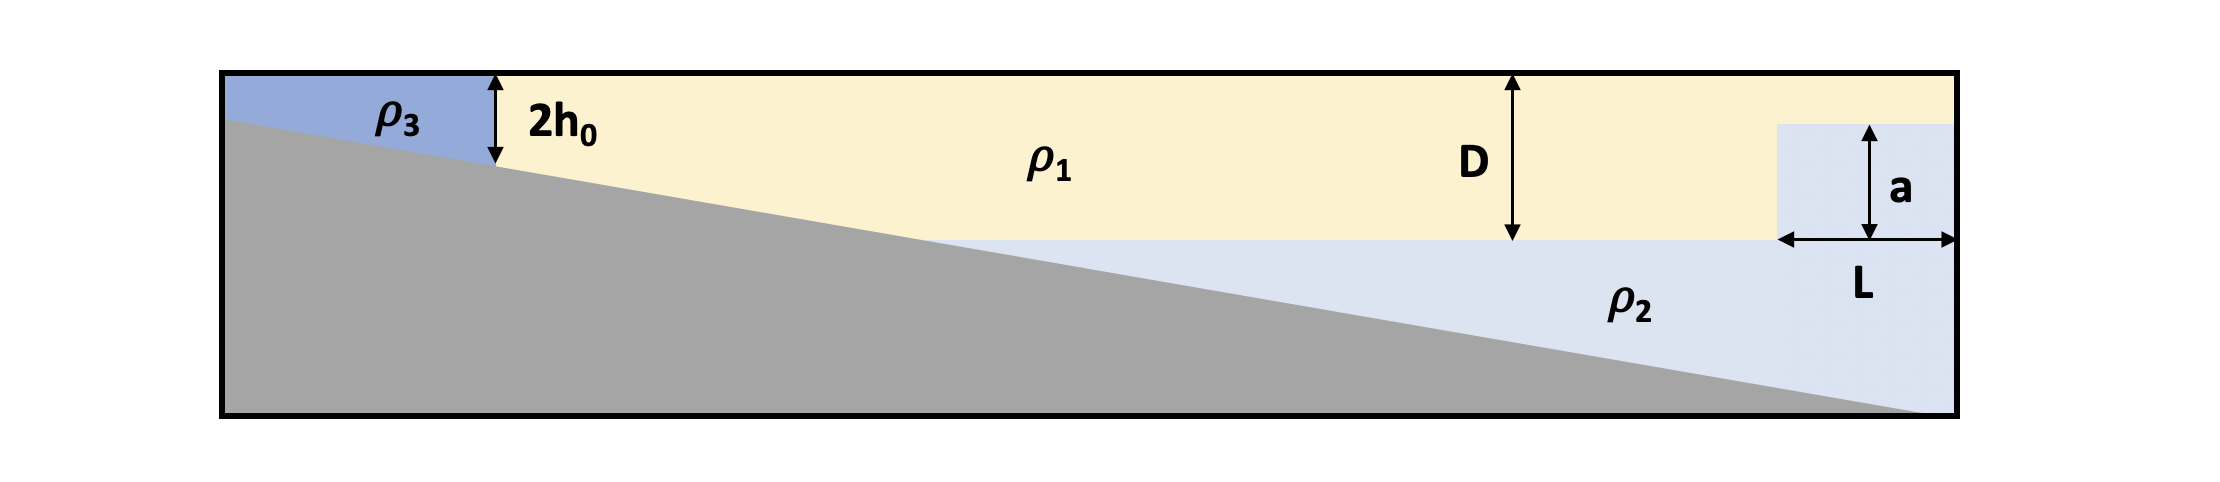

#### 4.1 Grid size

Let's build a grid with dimensions (x: 320, y:1, z: 180)

In [293]:
nx = 320 # grid points in x-direction
ny = 1 # grid points in y-direction
nz = 180 # grid points in z-direction

#### 4.2 Domain size and sloping topography

Let's create the numerical domain size at scale 1:500.

Then:

- Domain length:   $Lx = 6000m$
- Domain height:   $H =   600m$
- Slope angle:     $\alpha = 5.4$
- Slope intersect: $b = Lx\cdot\tan{\theta} - H = -32.83m$
- Slope:           $m = -tan(\alpha)$
- Slope function:  $d = m\cdot x + b$

In [294]:
alpha = 5.4 # slope angle
Lx = 6e3  # meridional extent of domain [m]
H = 600  # Nominal depth of model [m]
b = Lx * np.tan(np.deg2rad(alpha)) - H  # Slope intersect
m = - np.tan(np.deg2rad(alpha))  # Slope

# build x-coordinate with uniform x-spacing

dx = np.empty(shape=[nx])
dx.fill(Lx / nx)
x = np.cumsum(dx)

# build z-coordinate with uniform z-spacing
dz = H / nz
z = np.arange(-dz / 2, -H, -dz)

# build slope
d = m * x + b
d[0] = 0.0

#### 4.3 Initial conditions: temperature field

Density in this numerical setup only depends on temperature t. Using reference temperature $t_0$ and thermal expansion coefficient $\alpha$, temperature translates to density and vice versa as follows:

$$
\rho = \rho_0 \left(1-\alpha\left(t-t_0\right)\right)
$$

$$
t = \frac{(\rho_0 - \rho)}{\rho_0\alpha} + t_0
$$


Lets set $\rho_0 = \rho_1 = 1000 kg/m^3$ and $t_0 = 10^{\circ}C$. The rest can be computed using the equations in 2 and 4.3.

In [295]:
# set Froude number
Fr = 0.28

# set/derive additional parameters
talpha = 2.0e-4
Ri = 3.9
D = 300
h_0 = 27
L = 1000
a = Fr*L

# build functions to compute temperatures from densities
def calc_t(rho, rho_0, t_0, alpha):
    t = (rho_0 - rho) / (rho_0 * alpha) + t_0
    return t

# build function to compute rho_3 when rh0_1 and rho_2 are set following the equations in section 2
def calc_rho_3(rho_1, rho_2, Ri, D, h_0):
    rho_3 = ((rho_2 - rho_1) * D / Ri / (h_0) + rho_1)
    return rho_3

# Set (reference) densities
rho_0 = 1000
rho_1 = 1000
rho_2 = 1000.05

# compute rho_3 from set densities
rho_3 = calc_rho_3(rho_1, rho_2, Ri, D, h_0)


# Set (reference) temperatures
t_0 = 10

# compute rest of temperatures
t_1 = calc_t(rho_1, rho_0, t_0, talpha)
t_2 = calc_t(rho_2, rho_0, t_0, talpha)
t_3 = calc_t(rho_3, rho_0, t_0, talpha)


### build temperature profile

# set background temperature field (t_1)
t = 0.01 * np.random.rand(nx, ny, nz) + t_1

# build denser lower layer (t_2)
t[:, :, z <= -D] = t_2

# build gravity plume layer (t_3). Here a different h_0 is chosen 
# since the original from the paper does not seem to be correct (evaluate equ. in 2 to see this)
t[d >= -180, :, :] = t_3

# build wave lock layer (t_2)
t[267:-1, :, z <= (D+a-H)] = t_2

###### 4.4 Surface cooling

In [296]:
# specify zero surface cooling 
Q = np.zeros_like(x)

#### 4.5 Plot conditions set in the above paragraphs

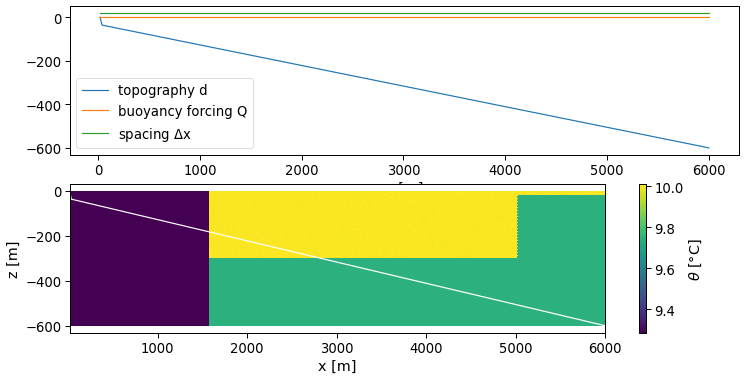

In [297]:
plt.figure(num=1, figsize=[12, 6])

plt.subplot(2, 1, 1)

plt.plot(x, d, label='topography d')
plt.plot(x.squeeze(), Q, label='buoyancy forcing Q')
plt.plot(x.squeeze(), dx, label='spacing $\Delta$x')
plt.legend()
plt.xlabel('x [m]')

plt.subplot(2, 1, 2)

cmesh = plt.pcolormesh(x.squeeze(), z, t.squeeze().T)
plt.plot(x, d, 'w')
cbar = plt.colorbar(cmesh, label='$\\theta$ [$\degree$C]')
plt.xlabel('x [m]')
plt.ylabel('z [m]');

#### 4.6 Write settings to input binary file

In [298]:
# function to write binary output
def writefield(fname, data):

    with open(fname, "wb") as fid:
        if sys.byteorder == 'little': data.byteswap(True)
        data.tofile(fid)
        data.byteswap(True)

    print('write to file: ' + fname)

In [299]:
# write temperature file
writefield(path + 'T.init', t.T)

# write x-spacing file
writefield(path + 'dx.bin', dx)

# write bottom topography file
writefield(path + 'topog.slope', d)

# write buoyancy flux file
writefield(path + 'Qnet.forcing', Q)

write to file: /Users/ndettling/mitgcm/temp/MITgcm/verification/tutorial_plume_on_slope_Hoggs/input/T.init
write to file: /Users/ndettling/mitgcm/temp/MITgcm/verification/tutorial_plume_on_slope_Hoggs/input/dx.bin
write to file: /Users/ndettling/mitgcm/temp/MITgcm/verification/tutorial_plume_on_slope_Hoggs/input/topog.slope
write to file: /Users/ndettling/mitgcm/temp/MITgcm/verification/tutorial_plume_on_slope_Hoggs/input/Qnet.forcing


### 5. Additional settings

- in code/SIZE.h: set grid size (320,1,180)
- in input/data: set time stepping (I chose 1 sec and 12.000 time steps) and dz (3.3m)